<a href="https://colab.research.google.com/github/vfrantc/AWAN/blob/master/04_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot -q

In [2]:
import pandas as pd
import numpy as np

import livelossplot

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from glob import glob

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir data
!cp -r /content/drive/My\ Drive/prj_datamine/*.tfrec data

In [5]:
!ls data

test-0.tfrec  train-0.tfrec  train-3.tfrec  train-6.tfrec
test-1.tfrec  train-1.tfrec  train-4.tfrec  train-7.tfrec
test-2.tfrec  train-2.tfrec  train-5.tfrec  train-8.tfrec


In [6]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
IMAGE_SIZE = [224, 224]
TEST_FILENAMES = tf.io.gfile.glob('data/test*tfrec')
TRAIN_FILENAMES = tf.io.gfile.glob('data/train*tfrec')

In [7]:
def decode_image(image_data, channels=3):
  image = tf.image.decode_png(image_data, channels=channels)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.reshape(image, [*IMAGE_SIZE, channels])
  return image

def read_tfrecord(example):
  tfrec_format = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "ch0": tf.io.FixedLenFeature([], tf.string),
      "ch8": tf.io.FixedLenFeature([], tf.string),
      "ch16": tf.io.FixedLenFeature([], tf.string),
      "ch24": tf.io.FixedLenFeature([], tf.string),
      "ch31": tf.io.FixedLenFeature([], tf.string),
      "profile": tf.io.FixedLenFeature([31], tf.float32),
      "label": tf.io.FixedLenFeature([], tf.int64)}

  example = tf.io.parse_single_example(example, tfrec_format)
  image = decode_image(example['image'], channels=3)
  ch0 = decode_image(example['ch0'], channels=1)
  ch8 = decode_image(example['ch8'], channels=1)
  ch16 = decode_image(example['ch16'], channels=1)
  ch24 = decode_image(example['ch24'], channels=1)
  ch31 = decode_image(example['ch31'], channels=1)
  profile = example['profile']
  label = example['label']

  return image, ch0, ch8, ch16, ch24, ch31, profile, label

def preprocess(image, ch0, ch8, ch16, ch24, ch31, profile, label):
  image = tf.concat([image, ch0, ch8, ch16, ch24, ch31], axis=-1)
  return image, label

def load_dataset(filenames, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    dataset = dataset.map(preprocess)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAIN_FILENAMES)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [8]:
train_dataset = load_dataset(TRAIN_FILENAMES)
test_dataset = load_dataset(TEST_FILENAMES, ordered=True)

In [9]:
def count_items(ds):
  n = 0
  for _ in ds:
    n += 1
  return n

In [10]:
train = get_training_dataset()
test = get_test_dataset(ordered=True)

In [11]:
#num_train = count_items(train.unbatch())
#num_test = count_items(test.unbatch())

#print('num_train: {}'.format(num_train))
#print('num_test: {}'.format(num_test))

In [12]:
num_train = 8012
num_test = 2003

In [13]:
train_ys = []
for X, y in tqdm(train_dataset, total=num_train):
  train_ys.append(y.numpy())
print(np.unique(np.array(train_ys)))
print(train_ys[:20])

100%|██████████| 8012/8012 [00:34<00:00, 231.18it/s]

[0 1 2 3 4 5 6]
[5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 2, 5, 5, 4, 5, 4, 5, 5, 2]


In [14]:
classes =  [0, 1, 2, 3, 4, 5, 6]
class_weights = class_weight.compute_class_weight('balanced', classes, list(train_ys))
weights = {cl:weight for cl, weight in zip(classes, class_weights)}

In [15]:
weights

{0: 4.368593238822246,
 1: 2.7848453249913105,
 2: 1.3021290427433772,
 3: 12.440993788819876,
 4: 1.2860353130016051,
 5: 0.21338020666879728,
 6: 10.040100250626567}

In [28]:
test_ys = []
for X, y in tqdm(test_dataset, total=num_test):
  test_ys.append(y.numpy())
print(np.unique(np.array(test_ys)))
print(test_ys[:20])

num_classes = len(np.unique(np.array(test_ys)))

100%|██████████| 2003/2003 [00:08<00:00, 230.34it/s]

[0 1 2 3 4 5 6]
[5, 0, 2, 1, 4, 5, 4, 1, 5, 2, 5, 2, 4, 5, 5, 5, 1, 5, 5, 5]


In [29]:
test_ys[:20]

[5, 0, 2, 1, 4, 5, 4, 1, 5, 2, 5, 2, 4, 5, 5, 5, 1, 5, 5, 5]

# Train deformable chebychev from scratch


In [66]:
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 60:
        lr *= 0.2
    if epoch > 120:
        lr *= 0.2
    if epoch > 160:
        lr *= 0.2
    return lr

In [67]:
model = ResNet50(include_top=True, 
                 weights=None, 
                 input_tensor=None, 
                 input_shape=(224, 225, 8), 
                 pooling=None, 
                 classes=num_classes)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/applications/imagenet_utils.py:333: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 8 input channels.
  str(input_shape[-1]) + ' input channels.')


In [68]:
model.build((None, 224, 224, 8))

In [69]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 225, 8) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 231, 8)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 113, 64) 25152       conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 113, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

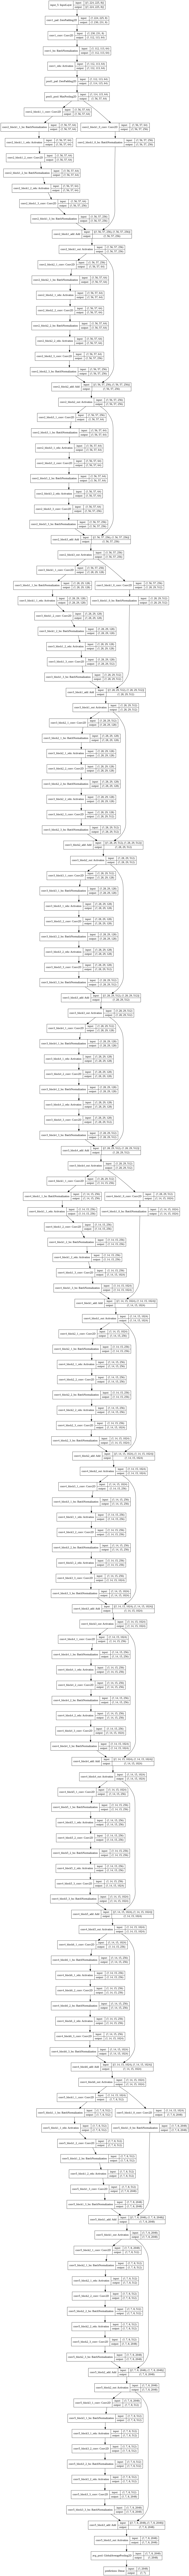

In [70]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [72]:
plot_losses = livelossplot.PlotLossesKerasTF()
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [73]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [74]:
num_train // BATCH_SIZE

125

In [75]:
num_test // BATCH_SIZE

31

In [ ]:
hist = model.fit(train, 
                 steps_per_epoch = (num_train // BATCH_SIZE), 
                 epochs=200, 
                 validation_data=test, 
                 callbacks=[reduce_lr],
                 class_weight=weights)

Epoch 1/200
125/125 [==============================] - 58s 463ms/step - loss: 2.3943 - accuracy: 0.3475 - val_loss: 3.3873 - val_accuracy: 0.0235
Epoch 2/200
125/125 [==============================] - 57s 454ms/step - loss: 1.8712 - accuracy: 0.4129 - val_loss: 1.9318 - val_accuracy: 0.3979
Epoch 3/200
125/125 [==============================] - 57s 458ms/step - loss: 1.6726 - accuracy: 0.4069 - val_loss: 2.7185 - val_accuracy: 0.0869
Epoch 4/200
125/125 [==============================] - 58s 465ms/step - loss: 1.5635 - accuracy: 0.4361 - val_loss: 1.6685 - val_accuracy: 0.3240
Epoch 5/200
125/125 [==============================] - 59s 476ms/step - loss: 1.7219 - accuracy: 0.4098 - val_loss: 1172.3096 - val_accuracy: 0.6675
Epoch 6/200
125/125 [==============================] - 55s 443ms/step - loss: 1.6273 - accuracy: 0.4310 - val_loss: 1.9969 - val_accuracy: 0.1318
Epoch 7/200
125/125 [==============================] - 56s 445ms/step - loss: 1.5238 - accuracy: 0.4462 - val_loss: 1.772

In [ ]:
pd.DataFrame(hist.history).plot(figsize=(16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
predictions = model.predict(test)

In [ ]:
y_pred = mlp.predict(test)

print(classification_report(np.argmax(y_pred, axis=-1), test_ys))

In [ ]:
print(accuracy_score(predictions, test_ys))